In [43]:
import os
import random
import sys
from genetic_algo import Formula, GeneticAlgorithm
from evolution_methods import *

In [198]:
# import visualization libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp


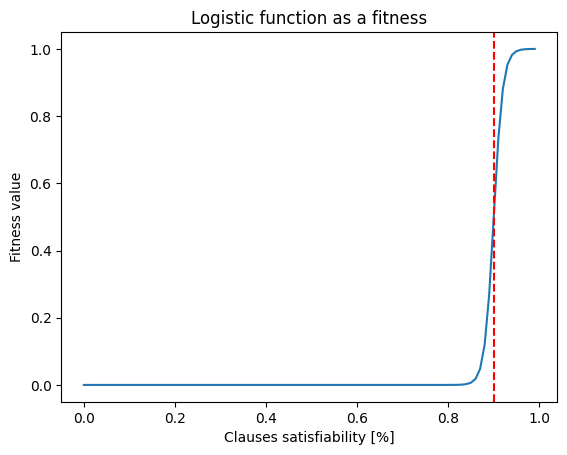

In [641]:
import math

steepness_param = 100
midpoint_curve = 0.9
# plot logistic function
# success_ratio = 1 / (1 + math.exp(-steepness_param * (x - midpoint_curve)))

def f(x):
    return 1 / (1 + math.exp(-steepness_param * (x - midpoint_curve)))

datay = [ f(x) for x in np.arange(0, 1, 0.01)]
datax = [ x for x in np.arange(0, 1, 0.01)]

plt.ion()
plt.plot(datax, datay)
# make a vertical line in the plot
plt.axvline(x=midpoint_curve, color='r', linestyle='--')
plt.ylabel('Fitness value')
plt.xlabel('Clauses satisfiability [%]')
plt.title('Logistic function as a fitness')
plt.show()


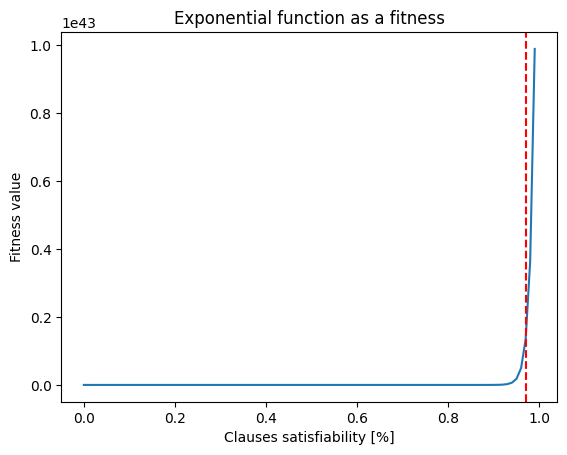

In [643]:
import math

steepness_param = 100
midpoint_curve = 0.97
# plot logistic function
# success_ratio = 1 / (1 + math.exp(-steepness_param * (x - midpoint_curve)))

def f(x):
    # exponential function
    return math.exp(x * steepness_param)

datay = [ f(x) for x in np.arange(0, 1, 0.01)]
datax = [ x for x in np.arange(0, 1, 0.01)]

plt.ion()
plt.plot(datax, datay)
# make a vertical line in the plot
plt.axvline(x=midpoint_curve, color='r', linestyle='--')
plt.ylabel('Fitness value')
plt.xlabel('Clauses satisfiability [%]')
plt.title('Exponential function as a fitness')
plt.show()


In [46]:
# load data from results.out
def get_loaded_data(file_name):
    results = {}
    with open(file_name, "r") as f:
        current_file = ""
        iteration_count = -1
        for line in f:

            if "Solving file:" in line:
                current_file = line.split(" ")[-1].strip()
                results[current_file] = {"solution": [], "iterations": []}
                continue

            if "Iteration" in line:
                results[current_file]["iterations"].append({"fitness": 0, "success_rate": 0.0})
                iteration_count += 1
                continue

            if "The best fitness" in line:
                results[current_file]["iterations"][iteration_count]["fitness"] = float(line.split(":")[-1])
                continue

            if "configuration success rate" in line:
                results[current_file]["iterations"][iteration_count]["success_rate"] = float(line.split(":")[-1].strip())
                continue

            if "Solution" in line:
                results[current_file]["solution"] = line.split(":")[-1]
                iteration_count = -1
                continue
    return results

# 'Dobre' napady na "experimenty"

- jedno nastavenie spustime viackrat, aby sme porovnali rozsah nahodnosti
- porovnanie kazdej metody (selekcia, krizenie, fitness, atd.) nad jednym reprezentativnym suborom. Kazda metoda sa spusti niekolkokrat a vypocitame priemer. Vysledky dame do jedneho grafu
- porovnanie 3-4 roznych nastaveni genetickeho algoritmu (kombinacia roznych metod dokopy) nad viacerymi (5-10) subormi. Kazde sa spusti viackrat a vytvorime tak niekolko (5-10) grafov, v kazdom porovname priemerne vysledky daneho nastavenia.
- program spustime nad (asi) vsetkymi instanciami a porovname, ci nasiel pre vsetky riesenia


# WHITE BOX

In [541]:
# load data from results/whitebox 
# and create a dataframe with all the data
import json

# list all files in the directory
files = os.listdir("all_results/white_box_huge/white_box/")

# create a dataframe with all the data
lines = []
white_box_dfs = []

for file in files:
    # open file
    with open("all_results/white_box_huge/white_box/" + file, "r") as f:
        # each line is json object with data
        for line in f:
            # load json object
            line = line.replace("'", '"').strip()
            data = json.loads(line)
            
            lines.append(data)

    df = pd.DataFrame(lines)
    white_box_dfs.append(df)
    lines = []

for index, _ in enumerate(white_box_dfs):
    df_temp = pd.DataFrame(white_box_dfs[index]['method'].tolist())
    white_box_dfs[index] = white_box_dfs[index].join(df_temp)
    white_box_dfs[index].drop("method", axis=1, inplace=True)


In [565]:
# print all unique values for population_size, reproduction_count, new_blood, elitism, survivors, max_iterations
# calculate the number of all possible combinations of these parameters

df = white_box_dfs[0]

ps_size = len(df['population_size'].unique())
rc_size = len(df['reproduction_count'].unique())
nb_size = len(df['new_blood'].unique())
el_size = len(df['elitism'].unique())
sv_size = len(df['survivors'].unique())
mi_size = len(df['max_iterations'].unique())

print("Population size: ", df['population_size'].unique())
print("Reproduction count: ", df['reproduction_count'].unique())
print("New blood: ", df['new_blood'].unique())
print("Elitism: ", df['elitism'].unique())
print("Survivors: ", df['survivors'].unique())
print("Max iterations: ", df['max_iterations'].unique())

mutation_rates = [0.01, 0.05, 0.1]

print("Number of all possible combinations: ", ps_size * rc_size * nb_size * el_size * sv_size * mi_size * len(mutation_rates))


Population size:  [100 500]
Reproduction count:  [100 200 250]
New blood:  [  0 100 200  80]
Elitism:  [ 0 10 50 30]
Survivors:  [ 0 10 20]
Max iterations:  [500 350]
Number of all possible combinations:  1728


In [545]:
# return dataframe table with only the success rate == 1
new_dfs = []
for index, _ in enumerate(white_box_dfs):
    new_dfs.append(white_box_dfs[index][white_box_dfs[index]["success_rate"] == 1])

# we have an array of dataframes, each were loaded from specific filename. Within each dataframe
# we have only the rows where the success rate was 1.0
# each row has a filename and a total_weight value
# take these dataframes and find the row with the biggest total_weight value for that specific filename
best_total_weights = []
for index, _ in enumerate(new_dfs):
    best_total_weights.append(new_dfs[index].groupby("filename").max().reset_index())

# sort by the max total_weight value
for index, _ in enumerate(best_total_weights):
    best_total_weights[index] = best_total_weights[index].sort_values(by=["total_weight"], ascending=False)

In [546]:
best_total_weights[0].head(1)

,filename,solution,success_rate,total_weight,perfomances,success,initial_population_method,fitness_function,selection_method,crossover_method,mutation_method,population_size,reproduction_count,new_blood,elitism,survivors,max_iterations
13,data/wuf50-218-R/wuf50-0132.mwcnf,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...",1.0,61664,"[2.0138810128059057e-05, 9.545938275879861e-06...",1.0,Random Initial Population,Logistic Fitness Function non-strict 100 0.99,Stochastic Universal Sampling Selection 2,Single Point Crossover 2,Bit Flip Mutation 0.01,500,250,80,30,10,350


In [566]:
white_box_dfs[1]["reproduction_count"].unique()

array([100, 200, 250])

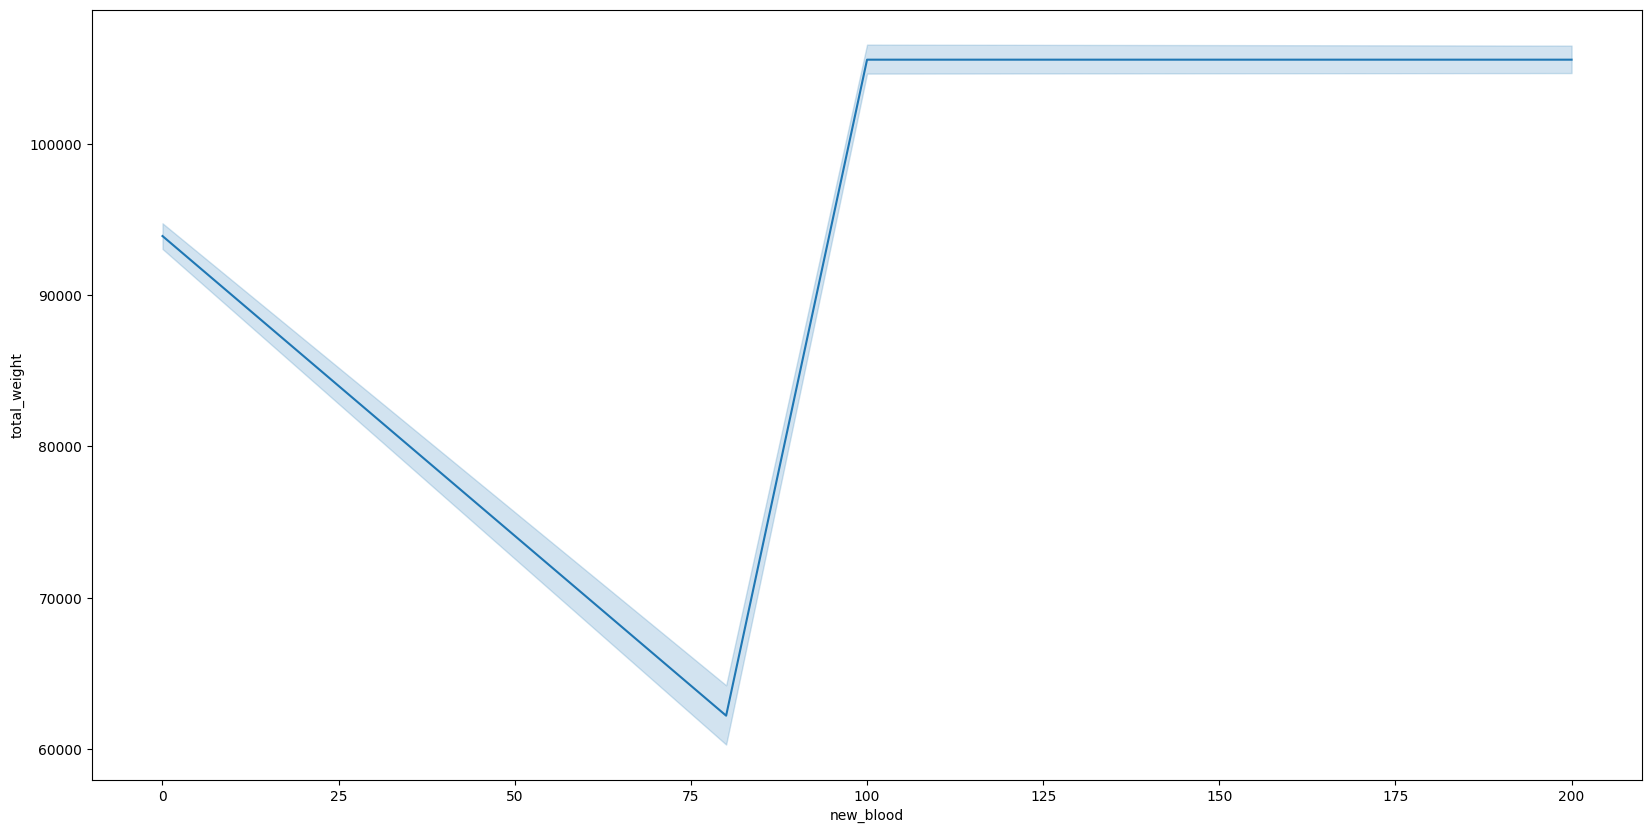

In [567]:
# concat dataframes and plot a performance graph of reproduction_count and total weight
df = white_box_dfs[0]
df = df.sort_values(by=["new_blood"], ascending=True)

plt.figure(figsize=(20, 10))
sns.lineplot(x="new_blood", y="total_weight", data=df)
plt.show()

## Testing methods

In [578]:
# load data from results/whitebox 
# and create a dataframe with all the data
import json

# list all files in the directory
files = os.listdir("all_results/white_box_methods/")

# create a dataframe with all the data
lines = []
white_box_methods_dfs = []

for file in files:
    # open file
    with open("all_results/white_box_methods/" + file, "r") as f:
        # each line is json object with data
        for line in f:
            # load json object
            line = line.replace("'", '"').strip()
            data = json.loads(line)
            
            lines.append(data)

    df = pd.DataFrame(lines)
    white_box_methods_dfs.append(df)
    lines = []

for index, _ in enumerate(white_box_methods_dfs):
    df_temp = pd.DataFrame(white_box_methods_dfs[index]['method'].tolist())
    white_box_methods_dfs[index] = white_box_methods_dfs[index].join(df_temp)
    white_box_methods_dfs[index].drop("method", axis=1, inplace=True)


In [611]:
df["filename"].unique()

array([], dtype=object)

In [ ]:
# get the rows with the same filename

for index, df in enumerate(white_box_methods_dfs):
    print(index)
    for filename in df["filename"].unique():
        new_df = df[df["filename"] == filename]

        # select only those that have crossover_method == Single Point Crossover

        new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
        new_df = new_df[new_df["selection_method"].str.contains("Roulette Selection")]

        # scale the success rate to 100%
        # new_df["success_rate"] = new_df["success_rate"] * 100

        # plot the bar graph between total_weight
        plt.figure(figsize=(20, 10))
        sns.barplot(x="fitness_function", y="total_weight", data=new_df)
        # add title
        plt.title("Average success rate for with static Single Point Crossover and Tournament Selection")
        
        # add labels
        plt.xlabel("Fitness function")
        plt.ylabel("Total weight value")

        # add stickers
        for p in plt.gca().patches:
            plt.gca().annotate('{:}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        plt.show()


### Fitness functions

In [715]:
white_box_methods_dfs[0]["fitness_function"].unique()

array(['Success Rate Fitness Function strict',
       'Logistic Fitness Function non-strict 100 0.99',
       'Prioritized Fitness Function 0.2 0.8',
       'Exponential Fitness Function non-strict 2 0.5 0.99'], dtype=object)

Text(0, 0.5, 'Mapped optimal weight value [%]')

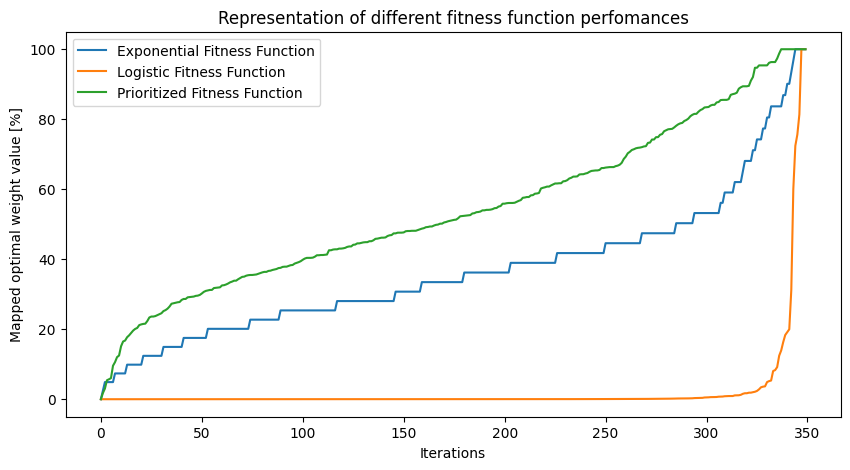

In [761]:
# get the rows with the same filename
data_index = 0
# EXPONENTIAL FITNESS FUNCTION
df = white_box_methods_dfs[data_index]
new_df = df[df["filename"] == filename]
# select only those that have crossover_method == Single Point Crossover
new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
new_df = new_df[new_df["fitness_function"].str.contains("Exponential Fitness Function")]

# scale the success rate to 100%
# new_df["success_rate"] = new_df["success_rate"] * 100

# plot the line graph of performances between iterations and total_weight
performance = new_df["perfomances"].iloc[0]
plt.figure(figsize=(10, 5))
x = np.arange(0, len(performance))
y = performance
# sort y
y_exp = sorted(y)

# map the values between 0 and 1
y_exp = [((i - min(y_exp)) / (max(y_exp) - min(y_exp))) * 100 for i in y_exp]
# add line to the plot
plt.plot(x, y_exp)

# add another line with the best total weight value
# plt.axhline(y=new_df["total_weight"].iloc[0], color='r', linestyle='-')

# LOGISTIC FITNESS FUNCTION
df = white_box_methods_dfs[data_index]
new_df = df[df["filename"] == filename]
new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
new_df = new_df[new_df["fitness_function"].str.contains("Logistic Fitness Function")]

# add another line with x and y
y_logistic = sorted(new_df["perfomances"].iloc[0])
# map the values between 0 and 1
y_logistic = [((i - min(y_logistic)) / (max(y_logistic) - min(y_logistic))) * 100 for i in y_logistic]
# normalize to the same scale as exponential
plt.plot(x, y_logistic)

# PRIRORITIZED FITNESS FUNCTION
# add another line with the best total weight value
df = white_box_methods_dfs[data_index]
new_df = df[df["filename"] == filename]
new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
new_df = new_df[new_df["fitness_function"].str.contains("Prioritized Fitness Function")]

# add another line with x and y
y_priority = sorted(new_df["perfomances"].iloc[0])
# map the values between 0 and 1
y_priority = [((i - min(y_priority)) / (max(y_priority) - min(y_priority))) * 100 for i in y_priority]
# normalize to the same scale as exponential
plt.plot(x, y_priority)

plt.legend(["Exponential Fitness Function", "Logistic Fitness Function", "Prioritized Fitness Function"])

# add title
plt.title("Representation of different fitness function perfomances")
plt.xlabel("Iterations")
plt.ylabel("Mapped optimal weight value [%]")

In [755]:
white_box_methods_dfs[0].head(1)

,filename,solution,success_rate,total_weight,perfomances,success,initial_population_method,fitness_function,selection_method,crossover_method,mutation_method,population_size,reproduction_count,new_blood,elitism,survivors,max_iterations
0,data/wuf50-218-R/wuf50-01.mwcnf,"[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, ...",0.87156,177674,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.87156,Random Initial Population,Success Rate Fitness Function strict,Tournament Selection 2,Single Point Crossover 2,Bit Flip Mutation 0.01,500,250,80,30,10,350


### Selection

In [784]:
white_box_dfs[0]["selection_method"].unique()

array(['Tournament Selection 2', 'Roulette Selection', 'Rank Selection 2',
       'Boltzmann Selection 1',
       'Stochastic Universal Sampling Selection 2'], dtype=object)

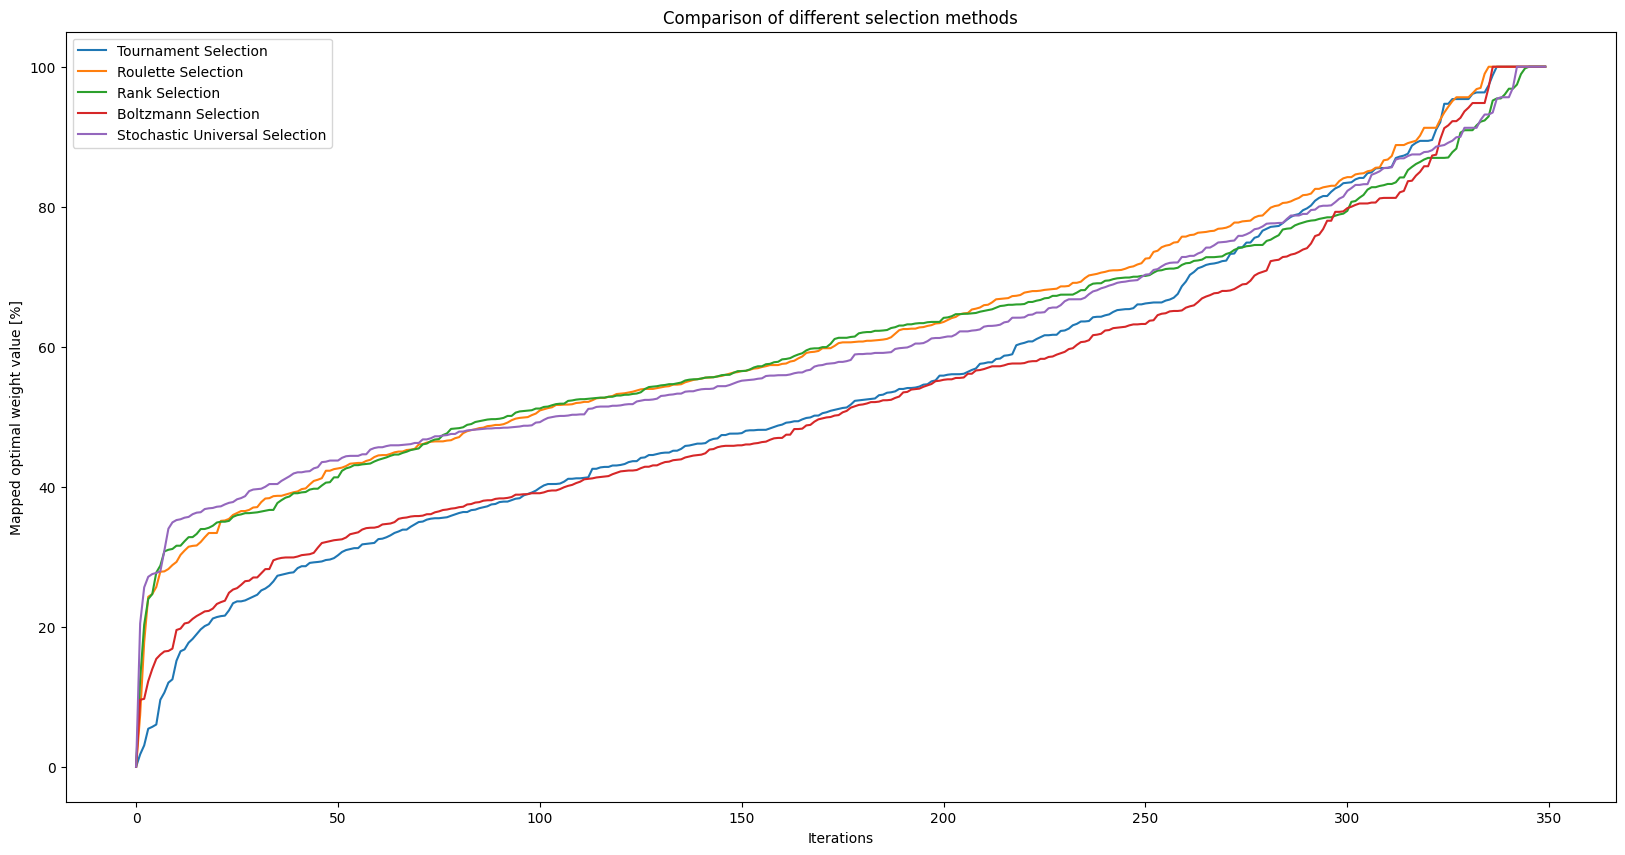

In [846]:
plt.figure(figsize=(20, 10))
x = np.arange(0, len(performance))

df = white_box_methods_dfs[0]
new_df = df[df["filename"] == filename]
new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
y_tournament = sorted(new_df["perfomances"].iloc[2])
# map the values between 0 and 1
y_tournament = [((i - min(y_tournament)) / (max(y_tournament) - min(y_tournament))) * 100 for i in y_tournament]
# normalize to the same scale as exponential
plt.plot(x, y_tournament)

df = white_box_methods_dfs[0]
new_df = df[df["filename"] == filename]
new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
new_df = new_df[new_df["selection_method"].str.contains("Roulette Selection")]
y_roulette = sorted(new_df["perfomances"].iloc[2])
# map the values between 0 and 1
y_roulette = [((i - min(y_roulette)) / (max(y_roulette) - min(y_roulette))) * 100 for i in y_roulette]
# normalize to the same scale as exponential
plt.plot(x, y_roulette)

# plt.legend(["Exponential Fitness Function", "Logistic Fitness Function", "Prioritized Fitness Function"])


df = white_box_methods_dfs[0]
new_df = df[df["filename"] == filename]
new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
new_df = new_df[new_df["selection_method"].str.contains("Rank Selection")]
y_rank = sorted(new_df["perfomances"].iloc[2])
# map the values between 0 and 1
y_rank = [((i - min(y_rank)) / (max(y_rank) - min(y_rank))) * 100 for i in y_rank]
# normalize to the same scale as exponential
plt.plot(x, y_rank)

df = white_box_methods_dfs[0]
new_df = df[df["filename"] == filename]
new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
new_df = new_df[new_df["selection_method"].str.contains("Boltzmann Selection")]
y_boltzman = sorted(new_df["perfomances"].iloc[2])
# map the values between 0 and 1
y_boltzman = [((i - min(y_boltzman)) / (max(y_boltzman) - min(y_boltzman))) * 100 for i in y_boltzman]
# normalize to the same scale as exponential
plt.plot(x, y_boltzman)

df = white_box_methods_dfs[0]
new_df = df[df["filename"] == filename]
new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
new_df = new_df[new_df["selection_method"].str.contains("Stochastic Universal")]
y_stochastic = sorted(new_df["perfomances"].iloc[2])
# map the values between 0 and 1
y_stochastic = [((i - min(y_stochastic)) / (max(y_stochastic) - min(y_stochastic))) * 100 for i in y_stochastic]
# normalize to the same scale as exponential
plt.plot(x, y_stochastic)

# set size
plt.legend(["Tournament Selection", "Roulette Selection", "Rank Selection", "Boltzmann Selection", "Stochastic Universal Selection"])
# add title
plt.title("Comparison of different selection methods")
plt.xlabel("Iterations")
plt.ylabel("Mapped optimal weight value [%]")
plt.show()

### Crossover

In [803]:
white_box_dfs[0]["crossover_method"].unique()

array(['Single Point Crossover 2', 'Uniform Crossover 2 2'], dtype=object)

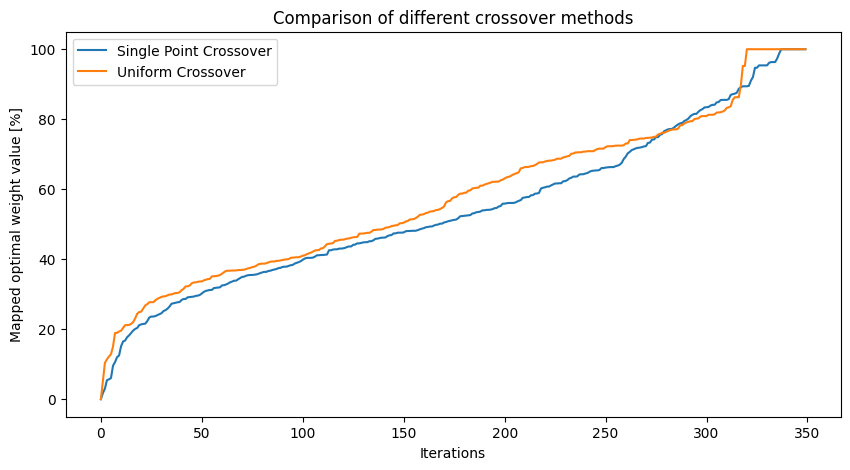

In [847]:
plt.figure(figsize=(10, 5))
x = np.arange(0, len(performance))

df = white_box_methods_dfs[0]
new_df = df[df["filename"] == filename]
new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
y_tournament = sorted(new_df["perfomances"].iloc[2])
# map the values between 0 and 1
y_tournament = [((i - min(y_tournament)) / (max(y_tournament) - min(y_tournament))) * 100 for i in y_tournament]
# normalize to the same scale as exponential
plt.plot(x, y_tournament)

df = white_box_methods_dfs[0]
new_df = df[df["filename"] == filename]
new_df = new_df[new_df["crossover_method"].str.contains("Uniform Crossover")]
new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
y_roulette = sorted(new_df["perfomances"].iloc[2])
# map the values between 0 and 1
y_roulette = [((i - min(y_roulette)) / (max(y_roulette) - min(y_roulette))) * 100 for i in y_roulette]
# normalize to the same scale as exponential
plt.plot(x, y_roulette)


# set size
plt.legend(["Single Point Crossover", "Uniform Crossover"])
# add title
plt.title("Comparison of different crossover methods")
plt.xlabel("Iterations")
plt.ylabel("Mapped optimal weight value [%]")
plt.show()

### Mutations

In [813]:
white_box_dfs[0]["mutation_method"].unique()

array(['Bit Flip Mutation 0', 'Bit Flip Mutation 0.01',
       'Bit Flip Mutation 0.1', 'Bit Flip Mutation 0.2'], dtype=object)

In [822]:
new_df[new_df["mutation_method"] == "Bit Flip Mutation 0"]

,filename,solution,success_rate,total_weight,perfomances,success,initial_population_method,fitness_function,selection_method,crossover_method,mutation_method,population_size,reproduction_count,new_blood,elitism,survivors,max_iterations


In [820]:
df = pd.concat(white_box_methods_dfs)
new_df = df[df["filename"] == filename]
# new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
# new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
new_df[new_df["mutation_method"] == "Bit Flip Mutation 0"]

,filename,solution,success_rate,total_weight,perfomances,success,initial_population_method,fitness_function,selection_method,crossover_method,mutation_method,population_size,reproduction_count,new_blood,elitism,survivors,max_iterations


162


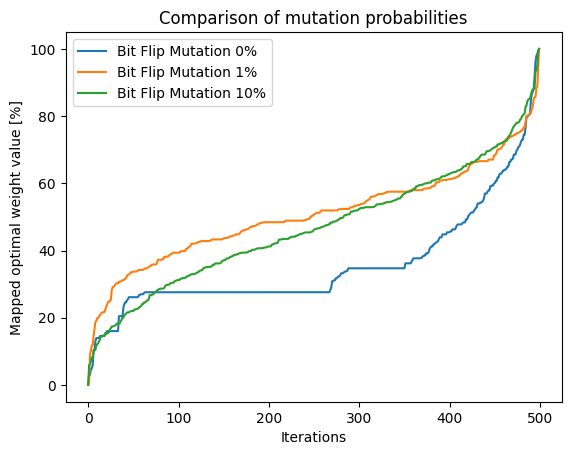

In [844]:
# plt.figure(figsize=(20, 10))

# concat all the dataframes
df = pd.concat(white_box_dfs)

new_df = df[df["filename"] == filename]
# new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
# new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
new_df = new_df[new_df["mutation_method"] == "Bit Flip Mutation 0"]
print(len(new_df))
y_tournament = sorted(new_df["perfomances"].iloc[0])
# map the values between 0 and 1
y_tournament = [((i - min(y_tournament)) / (max(y_tournament) - min(y_tournament))) * 100 for i in y_tournament]
# normalize to the same scale as exponential
x = np.arange(0, len(y_tournament))
plt.plot(x, y_tournament)

df = pd.concat(white_box_dfs)
new_df = df[df["filename"] == filename]
# new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
# new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
new_df = new_df[new_df["mutation_method"] == "Bit Flip Mutation 0.01"]
y_roulette = sorted(new_df["perfomances"].iloc[0])
# map the values between 0 and 1
y_roulette = [((i - min(y_roulette)) / (max(y_roulette) - min(y_roulette))) * 100 for i in y_roulette]
# normalize to the same scale as exponential
x = np.arange(0, len(y_roulette))
plt.plot(x, y_roulette)

# plt.legend(["Exponential Fitness Function", "Logistic Fitness Function", "Prioritized Fitness Function"])


df = pd.concat(white_box_dfs)
new_df = df[df["filename"] == filename]
# new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
# new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
new_df = new_df[new_df["mutation_method"] == "Bit Flip Mutation 0.1"]
y_rank = sorted(new_df["perfomances"].iloc[0])
# map the values between 0 and 1
y_rank = [((i - min(y_rank)) / (max(y_rank) - min(y_rank))) * 100 for i in y_rank]
# normalize to the same scale as exponential
x = np.arange(0, len(y_rank))
plt.plot(x, y_rank)

df = pd.concat(white_box_dfs)
new_df = df[df["filename"] == filename]
# new_df = new_df[new_df["crossover_method"].str.contains("Single Point Crossover")]
# new_df = new_df[new_df["selection_method"].str.contains("Tournament Selection")]
new_df = new_df[new_df["mutation_method"] == "Bit Flip Mutation 0.2"]
y_boltzman = sorted(new_df["perfomances"].iloc[0])
# map the values between 0 and 1
y_boltzman = [((i - min(y_boltzman)) / (max(y_boltzman) - min(y_boltzman))) * 100 for i in y_boltzman]
# normalize to the same scale as exponential
x = np.arange(0, len(y_boltzman))
# plt.plot(x, y_boltzman)

# set size
plt.legend(["Bit Flip Mutation 0%", "Bit Flip Mutation 1%", "Bit Flip Mutation 10%"])
# add title
plt.title("Comparison of mutation probabilities")
plt.xlabel("Iterations")
plt.ylabel("Mapped optimal weight value [%]")
plt.show()

## Performance measures

In [146]:
# calculate percentage of successful configurations (success_rate == 1)
# for all dataframes

for index, df in enumerate(dfs):
    print("Folder:", files[index][:-4], end=": ")
    print(100 * df[df['success_rate'] == 1].shape[0] / df.shape[0], "%")

Folder: wuf50-218-R: 0.08723466123873219 %
Folder: wuf50-218R-R: 0.07269026677327906 %


In [157]:
# give me unique values for each file
# concat
df = pd.concat(best_total_weights)

print("Population size: ", df['population_size'].unique())
print("Reproduction count: ", df['reproduction_count'].unique())
print("New blood: ", df['new_blood'].unique())
print("Elitism: ", df['elitism'].unique())
print("Survivors: ", df['survivors'].unique())
print("Max iterations: ", df['max_iterations'].unique())


Population size:  [500]
Reproduction count:  [250]
New blood:  [80]
Elitism:  [30]
Survivors:  [10]
Max iterations:  [350]


In [238]:
len(best_total_weights[0]["perfomances"][0])

350

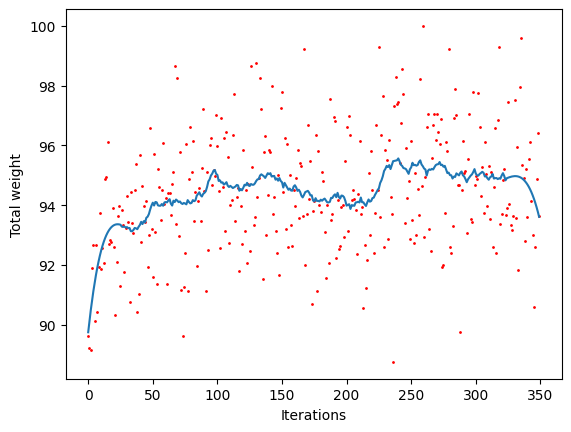

In [630]:
# each row has a solution column
# this contains a list of values
# create a plot for all of them in best_total_weights[0]

df = best_total_weights[0]

# plot df["solution"]
x = list(range(len(best_total_weights[0]["perfomances"][0])))

# best_total_weights[0]["perfomances"] is a column containing a lists of progress
# each list contains 350 values (max_iterations)
# we want to calculate the average of all the progress lists and plot it
# each index of new list will be the average of all the values at that index
# for example: new_list[0] = (list1[0] + list2[0] + list3[0]) / 3

index = 0
performances = best_total_weights[index]["perfomances"]
iteration_count = len(performances[0])
y = [0] * iteration_count

for i in range(len(performances)):
    for j in range(len(performances[i])):
        y[j] += performances[i][j]
    
for i in range(len(y)):
    y[i] = y[i] / len(performances)

# y = best_total_weights[0]["perfomances"][2]

# map the value to the range [0, 100] where 100 is the max value
max_val = max(y)
new_y = [i * 100 / max_val for i in y]


# smooth the y values
y_smooth = sp.signal.savgol_filter(new_y, 51, 3)


plt.plot(x, new_y, 'o', markersize=1, color="red")

plt.plot(x, y_smooth)


plt.xlabel("Iterations")
plt.ylabel("Total weight")
plt.show()



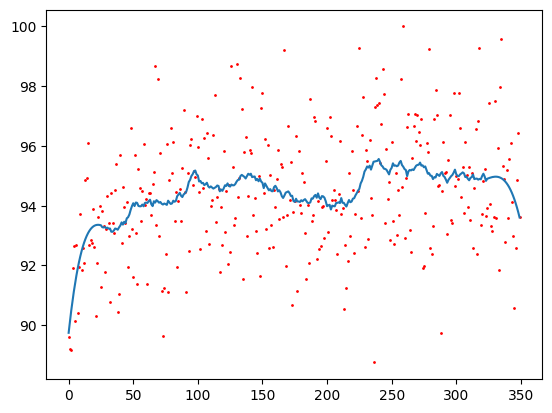

In [253]:
# plot df["performances"] for one specific file

df = best_total_weights[1]["perfomances"][1]

x = list(range(len(df)))

# map the value to the range [0, 100] where 100 is the max value
max_val = max(y)
new_y = [i * 100 / max_val for i in y]

# smooth the y values
y_smooth = sp.signal.savgol_filter(new_y, 51, 3)

plt.plot(x, new_y, 'o', markersize=1, color="red")
plt.plot(x, y_smooth)

# Black box

In [534]:
# load data from results/whitebox 
# and create a dataframe with all the data
import json

# list all files in the directory
files = os.listdir("black_box/")

# create a dataframe with all the data
lines = []
black_box_dfs = []

for file in files:
    # open file
    with open("black_box/" + file, "r") as f:
        # each line is json object with data
        for line in f:
            # load json object
            line = line.replace("'", '"').strip()
            line = line.replace("True", "true").strip()
            line = line.replace("False", "false").strip()
            data = json.loads(line)
            
            lines.append(data)

    df = pd.DataFrame(lines)
    black_box_dfs.append(df)

# for index, _ in enumerate(dfs):
#     df_temp = pd.DataFrame(dfs[index]['method'].tolist())
#     dfs[index] = dfs[index].join(df_temp)
#     dfs[index].drop("method", axis=1, inplace=True)


In [443]:
black_box_dfs[0][black_box_dfs[0]['success_rate'] == 1.0].shape[0]

0

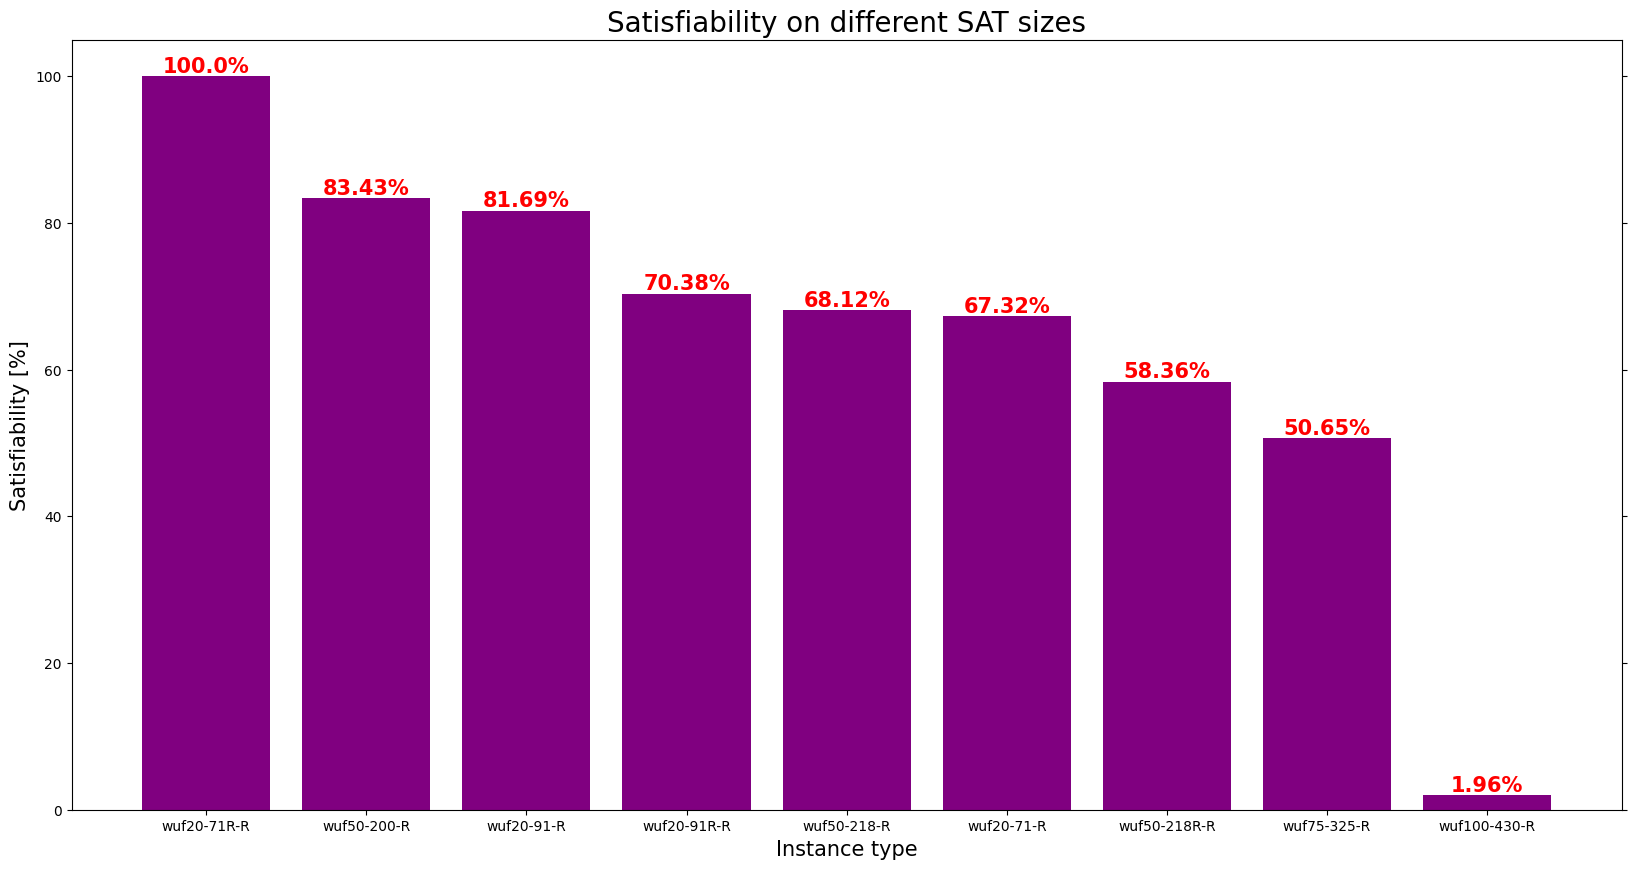

In [442]:
# give me all success_rate == 1.0 of first dataframe
# index = 1
# black_box_dfs[index][black_box_dfs[index]['success_rate'] == 1.0]

# give a plot where we get the number of success_rate == 1.0 for each dataframe
# and plot it

success_rates = []

for index, _ in enumerate(black_box_dfs):
    successful = black_box_dfs[index][black_box_dfs[index]['success_rate'] == 1.0].shape[0]
    rate = 0.01 + successful / black_box_dfs[index].shape[0]
    success_rates.append(rate)

# sort the success rates and files
success_rates, files = zip(*sorted(zip(success_rates, files), reverse=True))


# map it to the range [0, 100]
max_val = max(success_rates)
success_rates = [round(i * 100 / max_val, 2) for i in success_rates]


# plot it with a bar chart
# title
plt.figure(figsize=(20, 10))
plt.title("Satisfiability on different SAT sizes", fontsize=20)

plt.bar(files, success_rates, color="purple")
plt.xticks(files)
plt.xlabel("Instance type", fontsize=15)
plt.ylabel("Satisfiability [%]", fontsize=15)

# make the y axis be on both sides
plt.gca().yaxis.set_ticks_position('both')

# add stickers to the bars that dont't equal 100
for index, value in enumerate(success_rates):
    # if value != 100:
        # add sticker
    plt.text(index, value, str(value) + "%", ha='center', va='bottom', color="red", fontsize=15, fontweight="bold")

plt.show()



In [445]:
average_success_rate * 100

98.58023885547898

<BarContainer object of 36 artists>

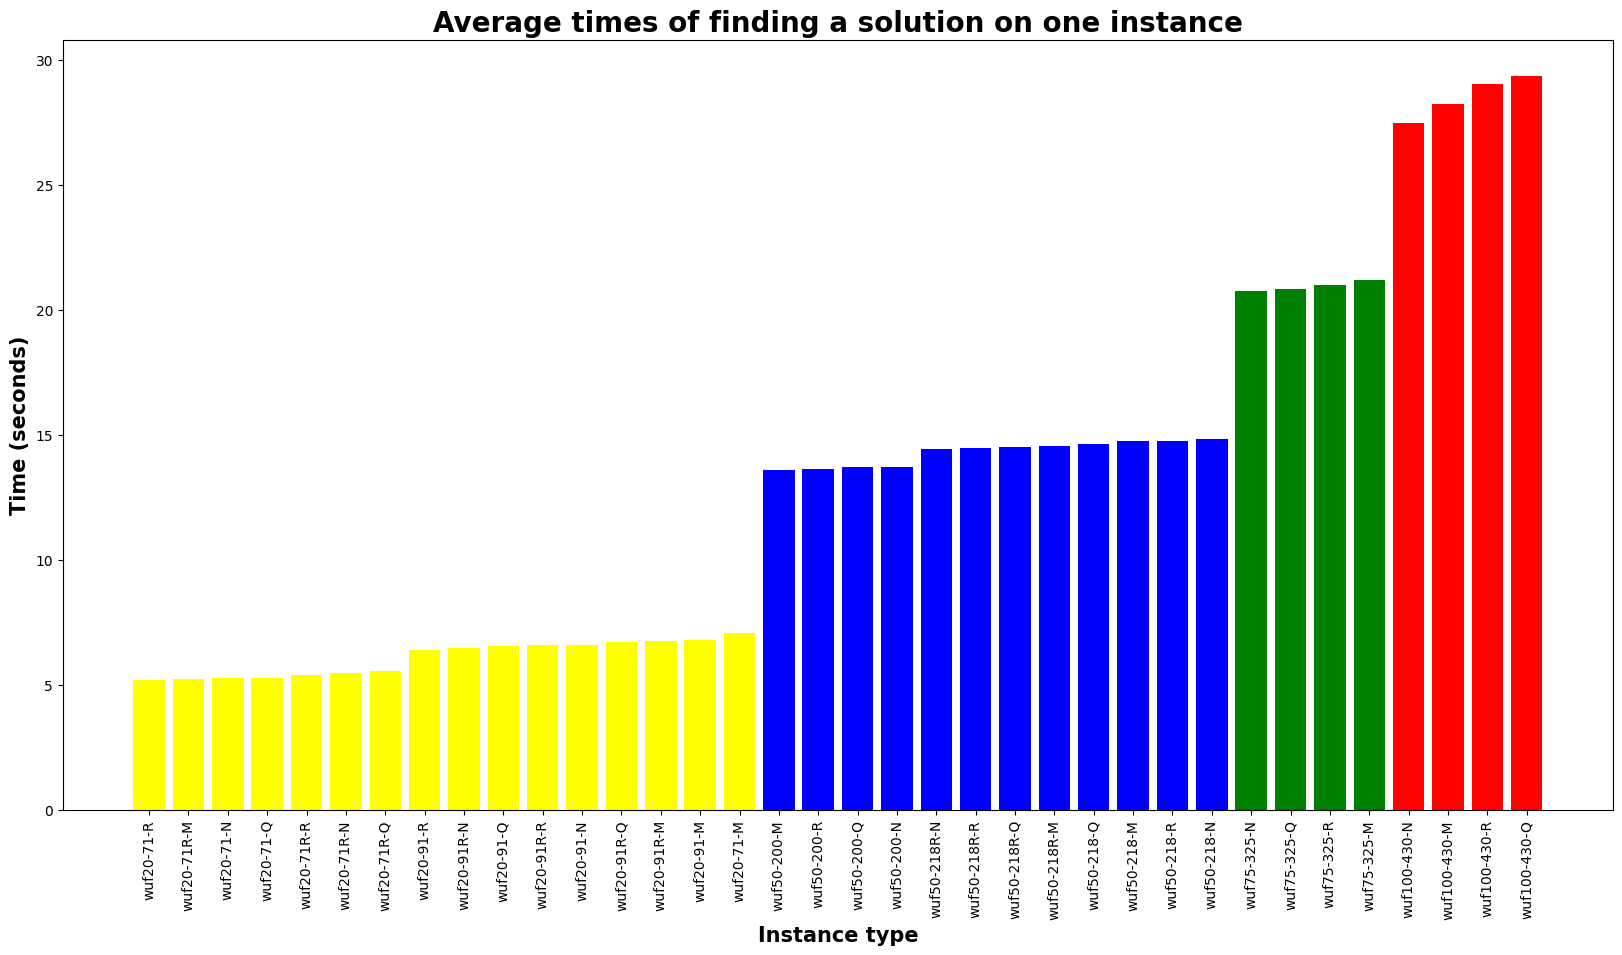

In [447]:
# timings
# load file "time"

with open("timing.txt", "r") as f:
    times = []
    files = []
    for line in f:
        # line is in format: "file: {file_name} time: {time}"
        # get the time
        if not line.startswith("file:"):
            continue

        line = line.split(" ")
        time = line[-1].strip()
        times.append(float(time))

        # get the file name
        file = line[1].strip()
        files.append(file)

# sort the lists
times, files = zip(*sorted(zip(times, files)))

# remove last 4 characters from the file name
files = [file[:-6] for file in files]

# remove "data/" from the start of the file
files = [file.split("/")[1] for file in files]

# separate the files into multiple lists based on their name
# their name have this format wuf{number1}-{number2}*
# where * can be any character besides number
# example of number1 can be 71R
# in that case we only want the 71
# some will have the same number1 and number2
# so we will separate them into lists based on their number1 and number2
# and then we will color code that into the plot
# get the number1 and number2 from the file name
number1 = [int(file.split("-")[0][3:]) for file in files]
number2 = [int(file.split("-")[1][:-1]) for file in files]

# get the unique number1 and number2
unique_number1 = list(set(number1))
unique_number2 = list(set(number2))

# create a dictionary with the number1 and number2 as keys
# and the files as values
files_dict = {}

for index, _ in enumerate(files):
    # get the file name
    file = files[index]

    # get the number1 and number2
    n1 = number1[index]
    n2 = number2[index]

    # create the key
    key = str(n1) + "-" + str(n2)

    # add the file to the dictionary
    if key in files_dict:
        files_dict[key].append(file)
    else:
        files_dict[key] = [file]

# create a list of colors
colors = ["red", "blue", "green", "yellow", "purple", "orange", "black", "pink", "brown", "gray", "olive", "cyan"]

# create a list of the colors for each file
colors_list = []

for index, _ in enumerate(files):
    # get the number1 and number2
    n1 = number1[index]
    n2 = number2[index]

    # create the key
    key = str(n1) + "-" + str(n2)

    # get the color
    color = colors[unique_number1.index(n1)]

    # add the color to the list
    colors_list.append(color)


# plot it
plt.figure(figsize=(20, 10))
# main title
plt.title("Average times of finding a solution on one instance", fontsize=20, fontweight="bold")
plt.xlabel("Instance type", fontsize=15, fontweight="bold")
plt.ylabel("Time (seconds)", fontsize=15, fontweight="bold")
plt.xticks(list(range(len(files))), files, rotation=90)

# plt.bar(files, times, color="purple")
plt.bar(files, times, color=colors_list)




In [448]:
# load all the data from data/*-opt.dat files
# they contains the optimal solution for each instance
# it will be in this format:
# uf50-0151 128061 <solution>
# this will be on every line

# we will save the file name we are reading from, file name that is on the line and the optimal solution value
# in a list of tuples
# the list will be called optimal_solutions
# the tuple will be in this format: (file_name, line_file_name, optimal_solution_value)

import glob
files = glob.glob("data/*-opt.dat")

# create a list of tuples
optimal_solutions = {}

for file in files:
    # open the file
    with open(file, "r") as f:
        # read the file line by line
        for line in f:
            # get the file name
            file_name = file.split("/")[1]

            # remove the -opt.dat from the file name and add /
            file_name = file_name[:-8] + "/"

            # get the line file name
            line_file_name = line.split(" ")[0]

            # get the optimal solution value
            optimal_solution_value = int(line.split(" ")[1])

            full_path = file_name + line_file_name + ".mwcnf"
            optimal_solutions[full_path] = optimal_solution_value


In [482]:
list(optimal_solutions.keys())[-1]

'wuf75-325-R/uf75-09.mwcnf'

In [487]:
"uf75-099.mwcnf/wuf75-09.mwcnf" in optimal_solutions

False

In [493]:
black_box_dfs[0].head(1)

,filename,solution,success_rate,total_weight,perfomances,success
0,data/wuf100-430-R/wuf100-01.mwcnf,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, ...",0.97907,57478,"[2.662158018205211e-06, 5.161319170466497e-07,...",False


In [536]:
# we will get a sum of all the optimal solutions and sum of all the found solutions in that file
# based on this we will calculate average error rate

count = 0
absolute_error = 0

file_error_rates = {}

for df in black_box_dfs:
    for index, row in df.iterrows():
        filename = row["filename"].split("/")
        filename[2] = filename[2].replace("wuf", "uf")
        filename = "/".join(filename[1:])

        # print(filename)
        if filename in optimal_solutions:
            # print(optimal_solutions[filename])
            optimal_solution = optimal_solutions[filename]
            found_solution = row["total_weight"]
            error_rate = (optimal_solution - found_solution) / optimal_solution
            absolute_error += abs(error_rate)

            file_error_rates[filename] = error_rate

            count += 1

# print(absolute_error / count)
# print(count)

In [537]:
# file_error_rates contain the error rate for each file. The key is the path to the file
# we want to create a new dictionary where we aggregate the error rates for each directory
# for example uf75-140/wuf75-09.mwcnf and uf75-140/wuf75-100.mwcnf will be in the same uf75-140 directory
# together so we add them in the same directory

# create a new dictionary
directory_error_rates = {}

# iterate over the file_error_rates
for key, value in file_error_rates.items():
    # get the directory name
    directory = key.split("/")[0]

    # add the error rate to the directory
    if directory in directory_error_rates:
        directory_error_rates[directory] += value
    else:
        directory_error_rates[directory] = 0

print(directory_error_rates)

{'wuf20-71-R': 0.540588277305594, 'wuf20-71R-R': 0.9931735077367787, 'wuf20-91-R': -76513.00514252654, 'wuf20-91R-R': -34799.76619462215, 'wuf50-218-R': -1973.5275913068274, 'wuf50-218R-R': -4219.716747068276, 'wuf75-325-R': -275.36094701620567}


<BarContainer object of 7 artists>

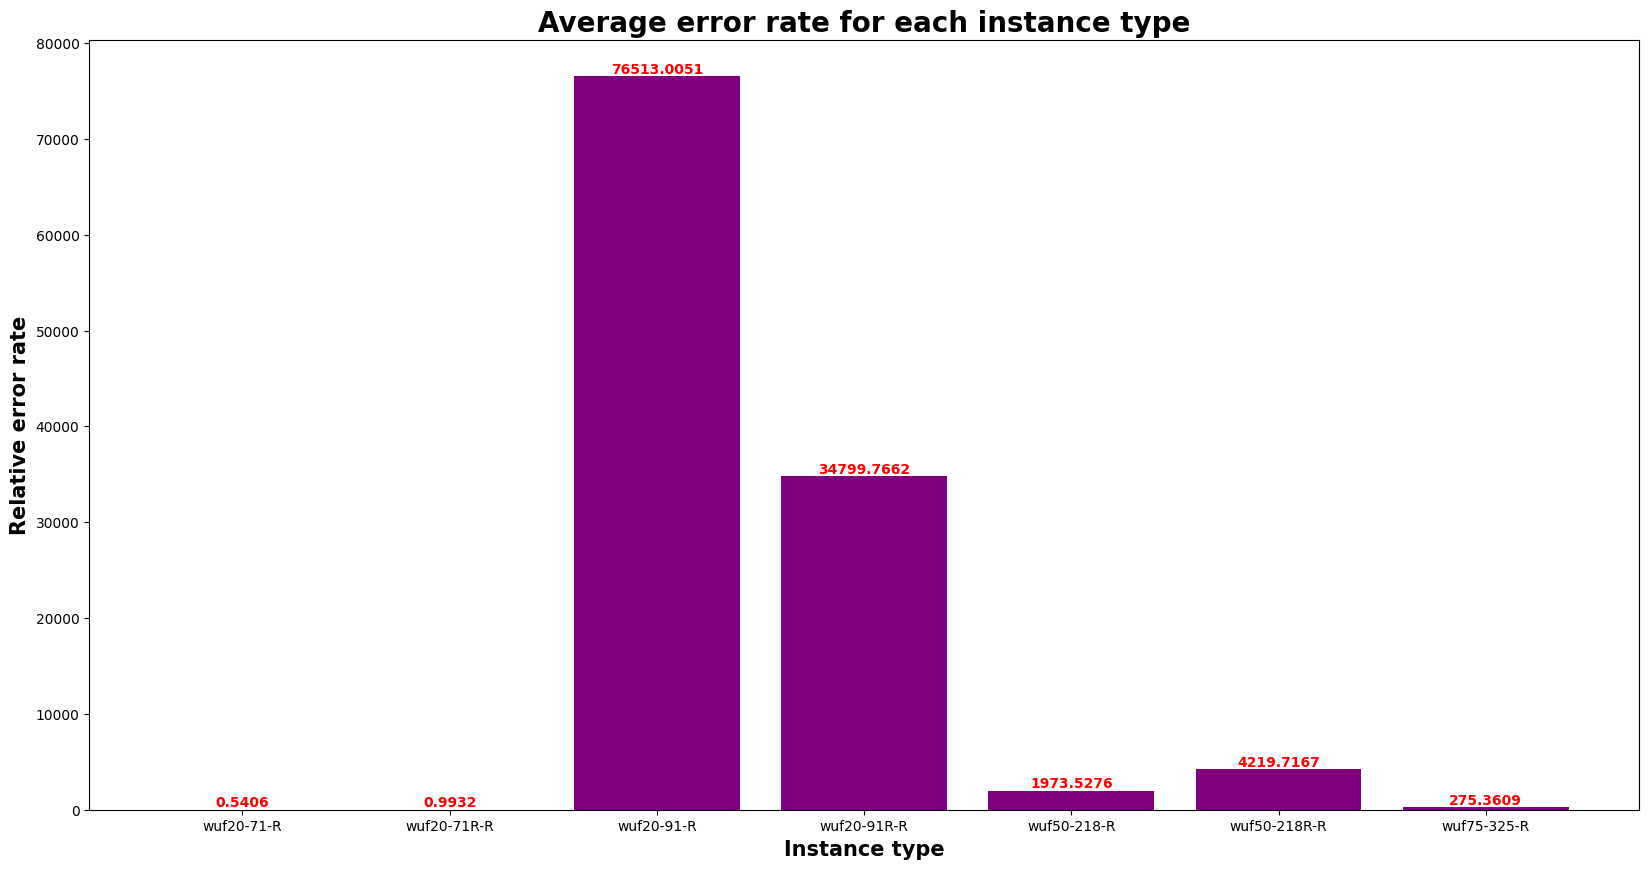

In [538]:
# plot the directory error rates into a table

y_values_abs = [abs(x) for x in list(directory_error_rates.values())]

# sor values and keys
# y_values_abs, keys = zip(*sorted(zip(y_values_abs, list(directory_error_rates.keys())), reverse=True)))

plt.figure(figsize=(20, 10))
plt.title("Average error rate for each instance type", fontsize=20, fontweight="bold")
plt.xlabel("Instance type", fontsize=15, fontweight="bold")
plt.ylabel("Relative error rate", fontsize=15, fontweight="bold")
plt.xticks(list(range(len(directory_error_rates))), list(directory_error_rates.keys()))

# add the stickers to the bars
for index, value in enumerate(y_values_abs):
    plt.text(index, value, str(round(value, 4)), ha="center", va="bottom", fontsize=10, fontweight="bold", color="red")

plt.bar(list(directory_error_rates.keys()), y_values_abs, color="purple")